In [98]:
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy
from scipy.optimize import curve_fit
from glob import glob
import pandas as pd

In [99]:
def file_type_checker(filename):
    """checks the file type, because the header will have diff formatting"""
    
    if filename[-3:] == "Spe":
        return "Spe"
    elif filename[-3:] == "mca":
        return "mca"
    else: return "error"

def file_parser(filename):

    #the function will fill and return these dictionaries:
    
    header_dict = {
        "DATE_MEAS": [],
        "MEAS_TIME": []
    }

    spectrum_dict = {
        "bins": [], 
        "counts": []
    }

    if file_type_checker(filename) == "Spe" :
        IS_DATA = False

        with open(filename, "r") as file:
            for line in file:
                line = line.strip()

            # if it's data, reset the flag
                if line == '$DATA:':
                    IS_DATA = True
                    continue
                elif line.startswith('$MEAS_TIM:'):
                    next_line = next(file).split(" ")
                    header_dict["MEAS_TIME"].append(float(next_line[0]))
                    IS_DATA = False
                elif line.startswith('$DATE_MEA:'):
                    next_line = next(file).strip()
                    header_dict["DATE_MEAS"].append(next_line)
                    IS_DATA = False

            #this is for all lines following # DATA
            #while IS_DATA == True:  
                if IS_DATA == True:
                    try:
                        spectrum_dict["counts"].append(float(line))
                    except ValueError:
                        continue   
        #change if bin range changes
        for i in range(len(spectrum_dict["counts"])):
            spectrum_dict["bins"].append(i)
        
        return header_dict, spectrum_dict

    elif  file_type_checker(filename) == "mca" :
        IS_DATA = False

        with open(filename, "r") as file:
            for line in file:
                line = line.strip()
    
                # if it's data, reset the flag
                if line.startswith('<<DATA>>'):
                    IS_DATA = True
                    continue
                elif line.startswith('REAL_TIME'):
                    line = line.strip()
                    header_dict["MEAS_TIME"].append(float(line[12:]))
                    IS_DATA = False
                elif line.startswith('START_TIME'):
                    line = line.strip()
                    header_dict["DATE_MEAS"].append(line[13:])
                    IS_DATA = False
                elif line.startswith("<<END>>"):
                    IS_DATA = False
                # else:
                #     print('hang on a sec')
                #     print(line)
    
                #this is for all lines following # DATA
                #while IS_DATA == True:  
                if IS_DATA == True:
                    try:
                        spectrum_dict["counts"].append(int(line))
                    except Exception as e:
                        print(e)
                        continue   
        #change if bin range changes
        for i in range(len(spectrum_dict["counts"])):
            spectrum_dict["bins"].append(i)
        
        return header_dict, spectrum_dict

    elif file_type_checker(filename) == "error":
        print("give me the right file type (mca or spe) pretty please!")


In [69]:
background_header, background_spec = file_parser("C:/Users/erisd/Desktop/Detector Lab/Background Files/Background_BGO.Spe")
#background_spec

In [67]:
real_time= background_header['MEAS_TIME']

background_cps = np.array(background_spec['counts'])/real_time

In [70]:
BGO_cps = {
    '0 degrees': [],
    '45 degrees': [],
    '90 degrees': [],
    '135 degrees': [],
    '165 degrees': []
    }
CdTe_cps = {
    '0 degrees': [],
    '90 degrees' : [],
    '135 degrees': []
}

In [116]:
def background_subtract(data, background):
    """
    Converts soectrum to units of counts/sec then subtracts background from data
    Inputs: data file, backgound file (.spe or .mca files)
    Outputs: returns dataframe object of bins and counts per second of background subtracted spectra and plot of bins by counts/sec
    """
    data_header, data_spectrum = file_parser(data)
    background_header, background_spectrum = file_parser(background)

    background_ct = background_header["MEAS_TIME"]
    data_ct = data_header["MEAS_TIME"]

    background_subtracted = (np.array(data_spectrum["counts"]) / data_ct) - (np.array(background_spectrum["counts"]) / background_ct)

    table = {
        'bins' : data_spectrum["bins"],
        'counts/sec' : background_subtracted
    }

    plt.close("all")
    fig, ax = plt.subplots(figsize = (8,8))
    ax.set_title(f"background subtracted spectra from: {data}")
    ax.set_xlabel("bins")
    ax.set_ylabel("counts / sec")
    ax.scatter(table["bins"], table["counts/sec"], s = 1, label = "Spectrum")

    ax.legend()
    plt.show()
    
    return pd.DataFrame(table)

In [102]:
BGO_deg_0 = "C:/Users/erisd/Desktop/Detector Lab/BGO Data/AM BGO.Spe"
BGO_deg_45 = "C:/Users/erisd/Desktop/Detector Lab/BGO Data/Am_BGO_45.Spe"
BGO_deg_90 = "C:/Users/erisd/Desktop/Detector Lab/BGO Data/Am_BGO_90.Spe"
BGO_deg_135 = "C:/Users/erisd/Desktop/Detector Lab/BGO Data/Am_BGO_135.Spe"
BGO_deg_165 = "C:/Users/erisd/Desktop/Detector Lab/BGO Data/Am_BGO_165.Spe"

CdTe_deg_0 = "C:/Users/erisd/Desktop/Detector Lab/CdTe Data/Am_CdTe_0deg.mca"
CdTe_deg_90 = "C:/Users/erisd/Desktop/Detector Lab/CdTe Data/Am_CdTe_90deg.mca"
CdTe_deg_135 = "C:/Users/erisd/Desktop/Detector Lab/CdTe Data/Am_CdTe_135deg.mca"

BGO_back = "C:/Users/erisd/Desktop/Detector Lab/Background Files/Background_BGO.Spe"
CdTe_back = "C:/Users/erisd/Desktop/Detector Lab/CdTe Data/Background_CdTe.mca"

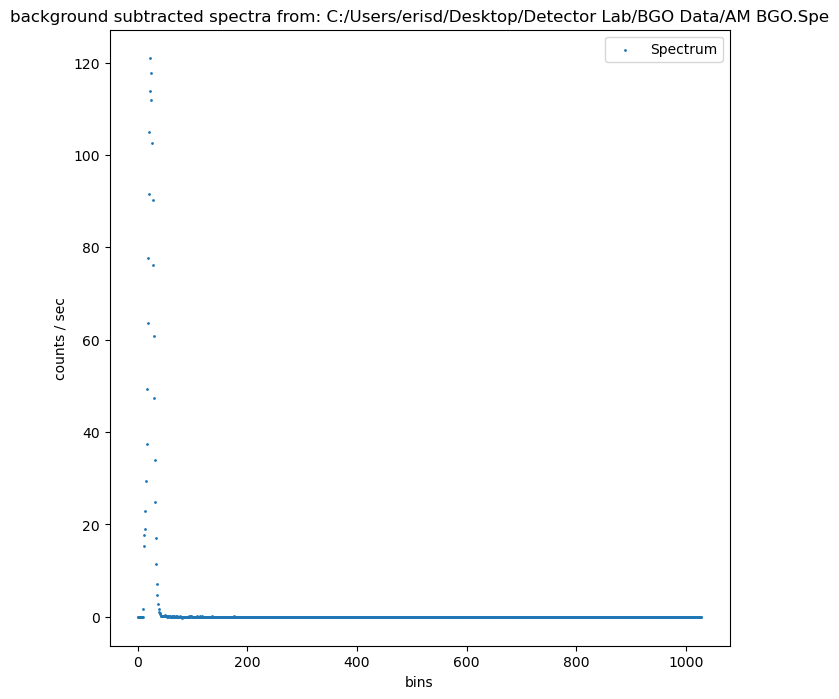

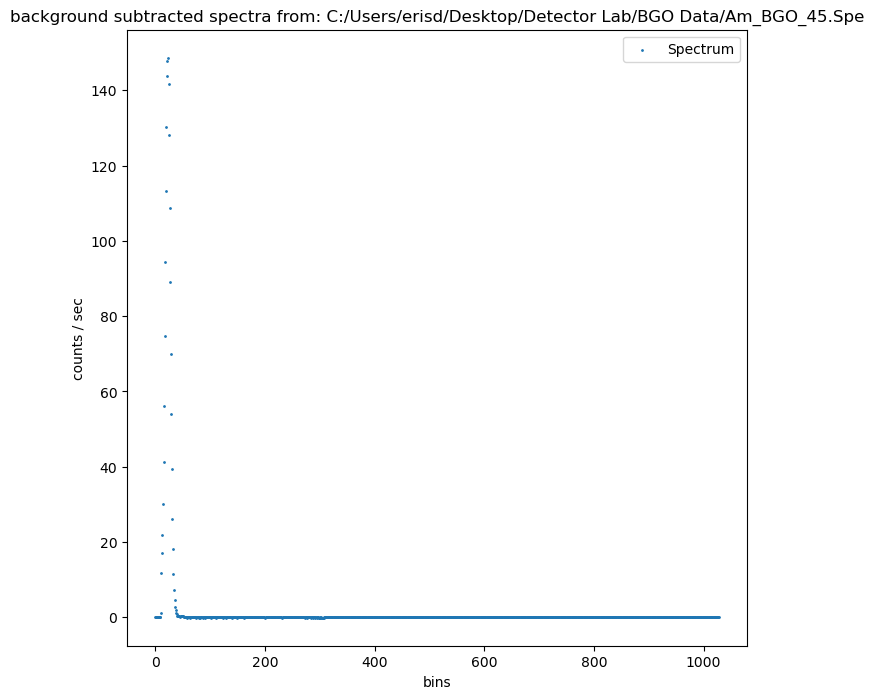

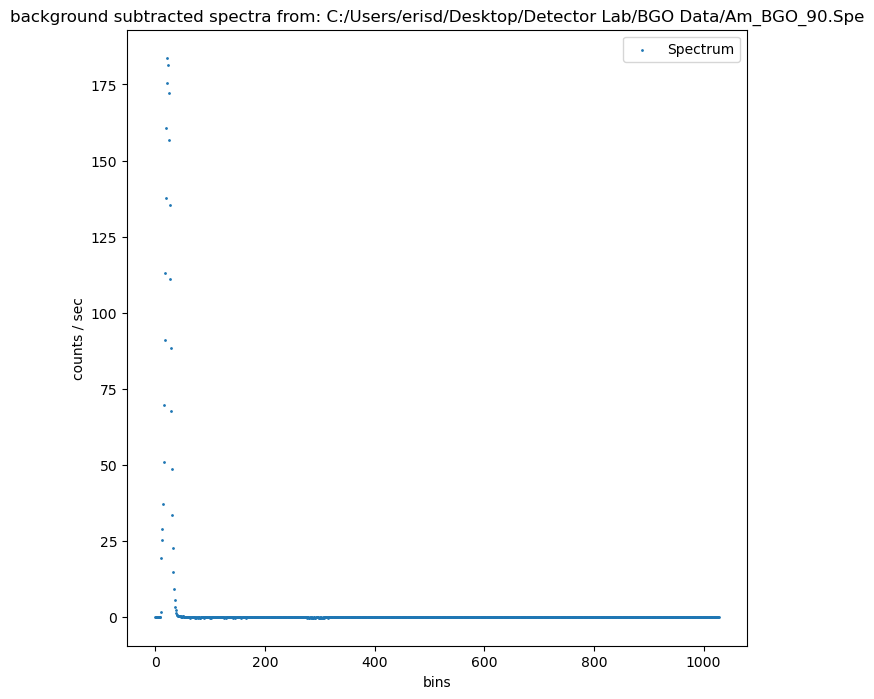

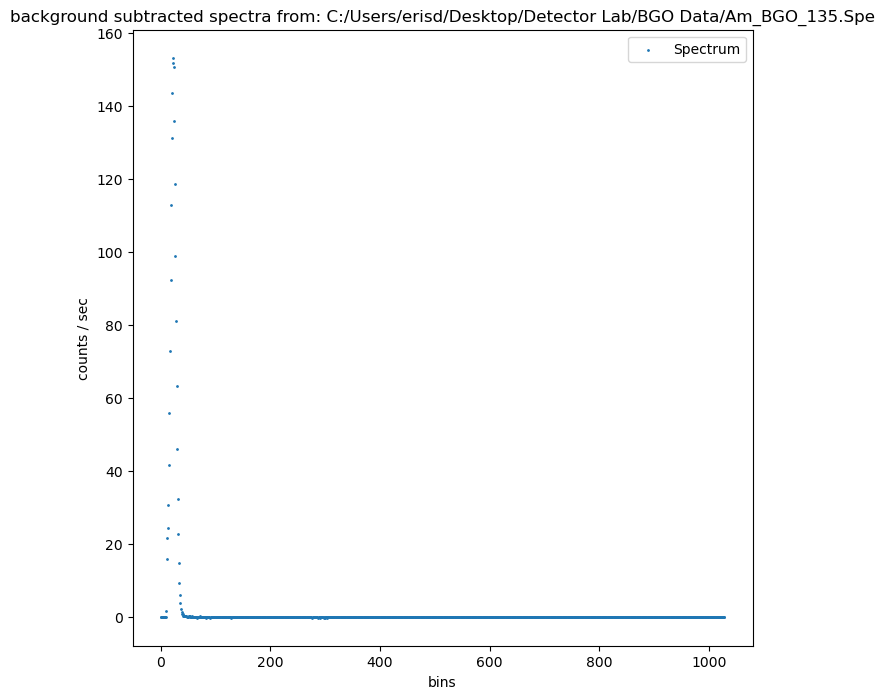

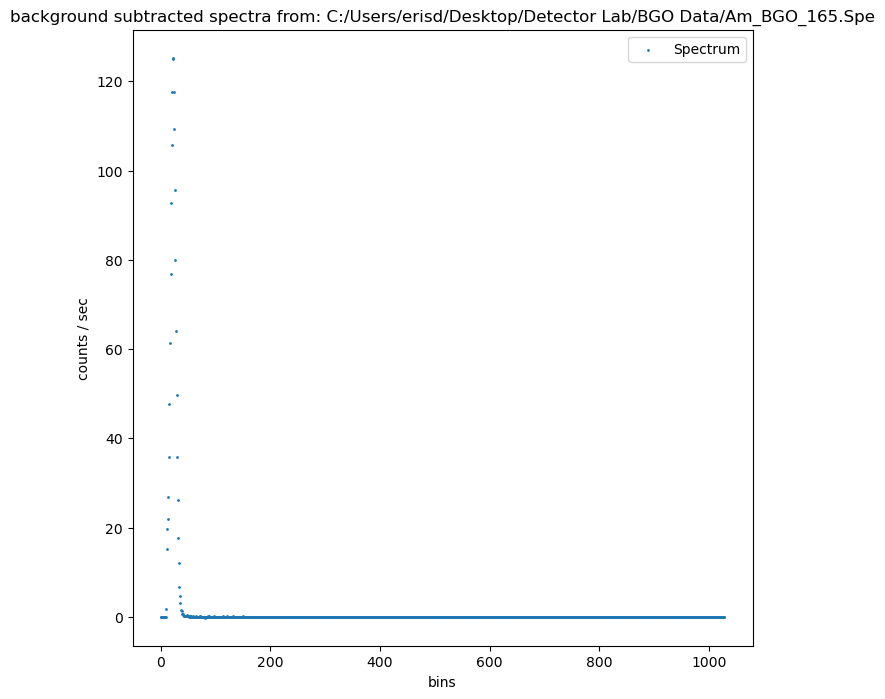

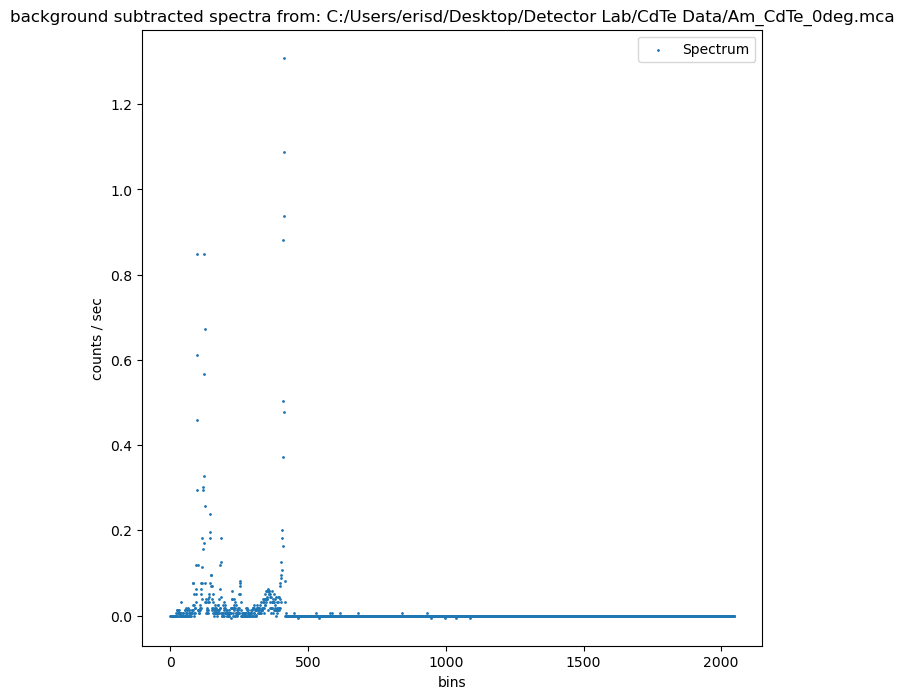

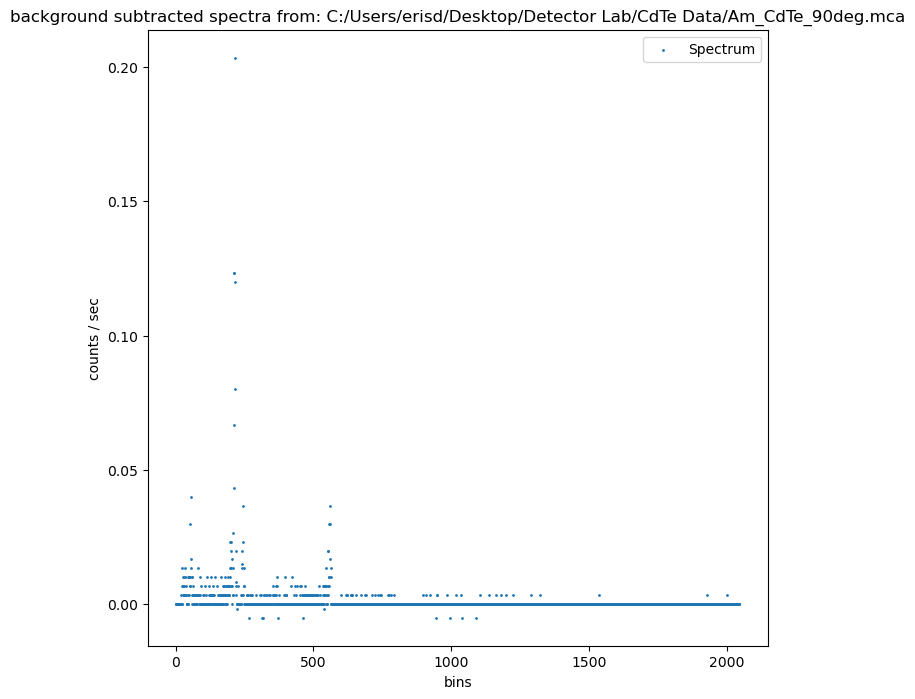

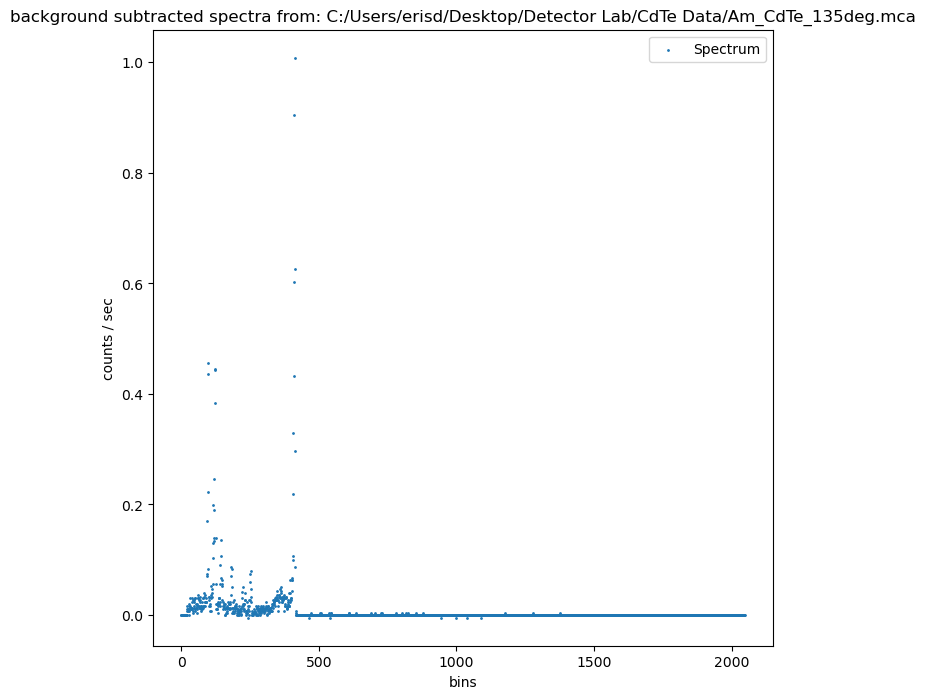

In [110]:
BGO_0_table = background_subtract(BGO_deg_0,BGO_back)
BGO_45_table = background_subtract(BGO_deg_45,BGO_back)
BGO_90_table = background_subtract(BGO_deg_90,BGO_back)
BGO_135_table = background_subtract(BGO_deg_135,BGO_back)
BGO_165_table = background_subtract(BGO_deg_165,BGO_back)

CdTe_0_table = background_subtract(CdTe_deg_0,CdTe_back)
CdTe_90_table = background_subtract(CdTe_deg_90,CdTe_back)
CdTe_135_table = background_subtract(CdTe_deg_135,CdTe_back)

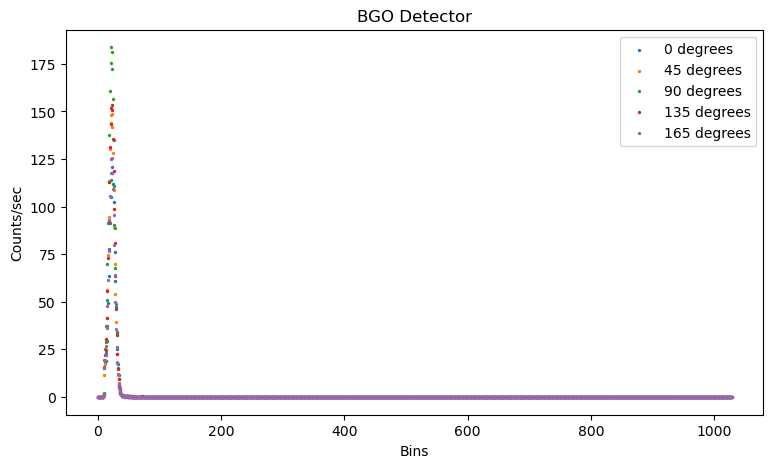

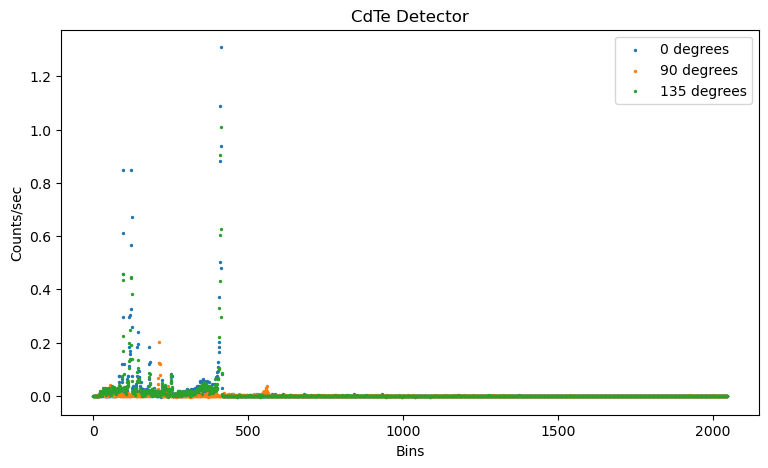

In [125]:
#plot each angle from source on top of each other
fig,ax = plt.subplots(figsize=(9,5))
ax.scatter(BGO_0_table['bins'],BGO_0_table['counts/sec'], s = 2, label = '0 degrees')
ax.scatter(BGO_45_table['bins'],BGO_45_table['counts/sec'], s = 2, label = '45 degrees')
ax.scatter(BGO_90_table['bins'],BGO_90_table['counts/sec'], s = 2, label = '90 degrees')
ax.scatter(BGO_135_table['bins'],BGO_135_table['counts/sec'], s = 2, label = '135 degrees')
ax.scatter(BGO_165_table['bins'],BGO_165_table['counts/sec'], s = 2, label = '165 degrees')
ax.set_title('BGO Detector')
ax.set_xlabel('Bins')
ax.set_ylabel('Counts/sec')
plt.legend()
plt.show()

fig,ax = plt.subplots(figsize=(9,5))
ax.scatter(CdTe_0_table['bins'],CdTe_0_table['counts/sec'], s = 2, label = '0 degrees')
ax.scatter(CdTe_90_table['bins'],CdTe_90_table['counts/sec'], s = 2, label = '90 degrees')
ax.scatter(CdTe_135_table['bins'],CdTe_135_table['counts/sec'], s = 2, label = '135 degrees')
ax.set_title('CdTe Detector')
ax.set_xlabel('Bins')
ax.set_ylabel('Counts/sec')
plt.legend()
plt.show()

In [ ]:
#investigate around peaks

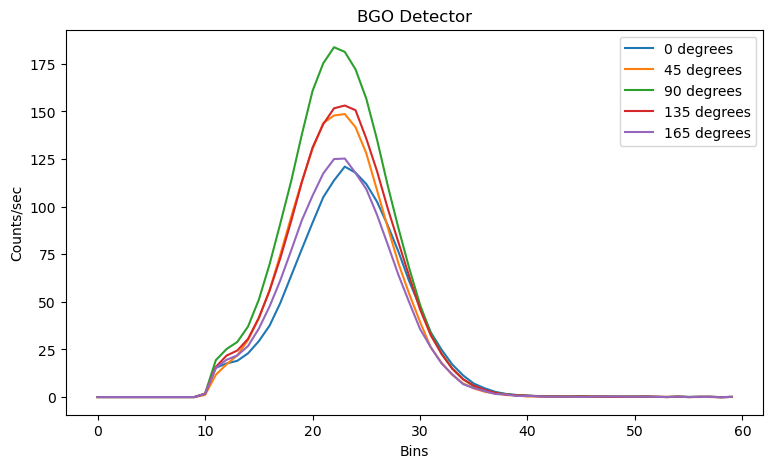

In [123]:
fig,ax = plt.subplots(figsize=(9,5))
ax.plot(BGO_0_table['bins'][0:60],BGO_0_table['counts/sec'][0:60], label = '0 degrees')
ax.plot(BGO_45_table['bins'][0:60],BGO_45_table['counts/sec'][0:60], label = '45 degrees')
ax.plot(BGO_90_table['bins'][0:60],BGO_90_table['counts/sec'][0:60], label = '90 degrees')
ax.plot(BGO_135_table['bins'][0:60],BGO_135_table['counts/sec'][0:60], label = '135 degrees')
ax.plot(BGO_165_table['bins'][0:60],BGO_165_table['counts/sec'][0:60], label = '165 degrees')
ax.set_title('BGO Detector')
ax.set_xlabel('Bins')
ax.set_ylabel('Counts/sec')
plt.legend()
plt.show()

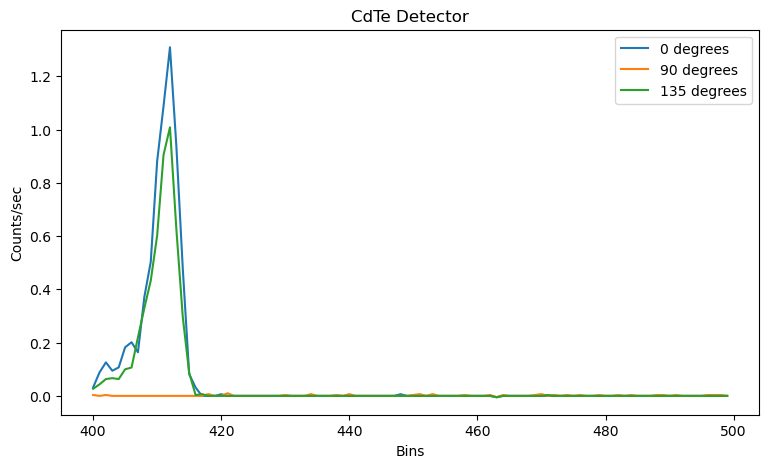

In [182]:
fig,ax = plt.subplots(figsize=(9,5))
ax.plot(CdTe_0_table['bins'][400:500],CdTe_0_table['counts/sec'][400:500], label = '0 degrees')
ax.plot(CdTe_90_table['bins'][400:500],CdTe_90_table['counts/sec'][400:500], label = '90 degrees')
ax.plot(CdTe_135_table['bins'][400:500],CdTe_135_table['counts/sec'][400:500], label = '135 degrees')
ax.set_title('CdTe Detector')
ax.set_xlabel('Bins')
ax.set_ylabel('Counts/sec')
plt.legend()
plt.show()

In [170]:
#fitting functions: 
def quadratic(x, a, b, c):
    """A quatratic function, used for curve fitting"""
    return a * (x**2) + b * x + c

def gaussian(x, mu, sig, amp):
    """A Gaussian function, used for scipi curve fit"""
    return amp * np.exp(-0.5 * (x-mu)**2 / sig**2) / np.sqrt(2 * np.pi * sig**2)

def compound_model(x, mu, sig, amp, a, b, c):
    """combines the quadratic fit of the background with the Gaussian fit which better represents the peak"""
    return quadratic(x, a, b, c) + gaussian(x, mu, sig, amp)

def fit_compound_model(x, y, p0=None):
    """
    Function to fit data using curve_fit and compound_model
    Inputs: x, y (list of x, y data)
    Outputs: popt (parameters array), pcov (covarience array) 
    """

    #if no p0 is passed, guess: 

    if p0 is None: 
        A_guess = np.max(y) - np.min(y)
        mu_guess = np.sum(x * y) / np.sum(y)
        sigma_guess = (np.max(x) - np.min(x)) / 10
        #getting the polynomial parameters: 
        background_y = y
        b_popt, b_pcov = curve_fit(quadratic, x, background_y, p0 = None)

    p0 = [mu_guess, sigma_guess, A_guess, *b_popt]
    popt, pcov = curve_fit(compound_model, x, y, p0 = p0)

    return popt, pcov

def print_uncertainties(pcov, popt):
    """a function to print out the parameters and their uncertanties"""
    uncertainties = np.sqrt(np.diag(pcov))
    #[mu0, sig0, amp0, a, b, c] 
    print("Parameters: \n")
    print(f"Baseline Polynomial Fit: ")
    print(f"a = {popt[3]} +/- {uncertainties[3]},")
    print(f"b = {popt[4]} +/- {uncertainties[4]}, ")
    print(f"c = {popt[5]} +/- {uncertainties[5]}")
    print(f"Gaussian Fit: ")
    print(f"mu0 = {popt[0]} +/- {uncertainties[0]},")
    print(f"sigma0 = {popt[1]} +/- {uncertainties[1]},")
    print(f"amp0 = {popt[2]} +/- {uncertainties[2]}")

def peak_finder(table):
    """finds peaks in data"""

    max_point = np.argmax(table["counts/sec"][10:]) #ignores the first ten bins incase of weird detector noise
    
    return int(max_point)

def ignore_peak(flux):
    """
    Function used to ignore the peak part of the data for plotting the baseline
    Input: y data (flux)
    Output: list of ajdusted y data, were values associated with the peak are replaced with mean flux
    """
    background_y = []
    mean_flux = np.mean(flux)
    flux_std = np.std(flux)
    for i in flux:
        if i > 1 : #0.5 * (flux_std): #if the flux is higher than this, the point is probably part of the peak
            background_y.append(mean_flux)
        else:
            background_y.append(i)
    return background_y

def gauss_fitter(table, peak_range):
    """
    Function to fit a gaussian to data and find the location of peaks
    Input: table of bins and counts/sec for a spectrum and a range of interest to look for peaks in
    Output: mu0 (popt[0] from the curve fit of a found peak), and some plots
    """
    
    
    background_y = ignore_peak(table["counts/sec"][peak_range])
    b_popt, b_pcov = curve_fit(quadratic, table["bins"][peak_range], background_y, p0 = None)
    quad_fit = quadratic(np.array(table["bins"][peak_range]), *b_popt)

    #plotting data with polynomial baseline fit overlaid:
    plt.close("all")
    fig, ax = plt.subplots(figsize  = (9,6))
    ax.set_title("Spectrum Data Plotted With Baseline Fitted")
    ax.set_xlabel("bins")
    ax.set_ylabel("counts per second")
    
    ax.plot(table["bins"][peak_range], table["counts/sec"][peak_range], ls = ":", label = "data")
    ax.plot(table["bins"][peak_range], quad_fit, ls = '--', label = "fit")
    ax.grid()
    ax.legend()
    plt.show()

    #fitting and plotting gauss model: 
    popt, pcov = fit_compound_model(np.array(table["bins"][peak_range]), np.array(table["counts/sec"][peak_range]))
    #compound_fit = compound_model(np.array(spectrum_dict["Wavelength"]), *popt)
    gauss_fit = gaussian(np.array(table["bins"][peak_range]), *popt[:3])
        
    fig, ax = plt.subplots(figsize = (9,6))
    
    ax.set_title("Spectrum Data Plotted With Gaussian Fit: Second Peak from the Left")
    ax.set_xlabel("bins")
    ax.set_ylabel("counts per second")
    
    ax.plot(table["bins"][peak_range], table["counts/sec"][peak_range], ls = ":", label = "data")
    ax.plot(table["bins"][peak_range], quad_fit, ls = '--', label = "baseline fit")
    #for some reason the line below works better than plotting compound model even though it should return the same thing?
    ax.plot(table["bins"][peak_range], gauss_fit + quad_fit, ls = '-', color = 'r', label = "gaussian fit") 
    ax.grid()
    ax.legend()
    plt.show()
    
    #printing out parameters and uncertainties:
    print_uncertainties(pcov, popt)
    
    return popt[0],popt[1]

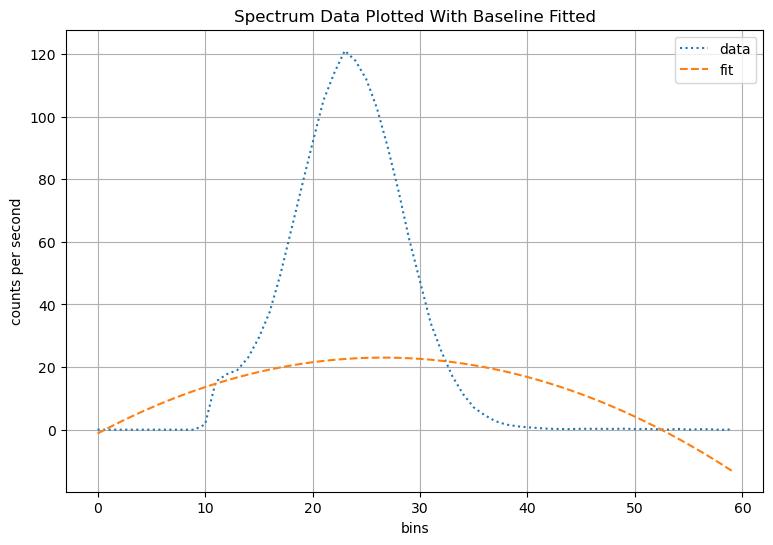

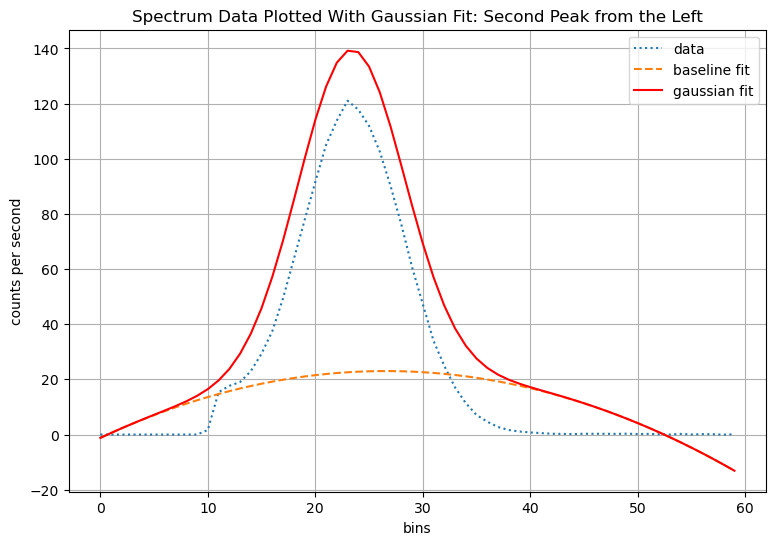

Parameters: 

Baseline Polynomial Fit: 
a = -0.001017589228612979 +/- 0.001555500464218064,
b = 0.03751396617287741 +/- 0.08872632097124539, 
c = 0.8184605632181927 +/- 0.8613337002922414
Gaussian Fit: 
mu0 = 23.354223184683732 +/- 0.046496903925940476,
sigma0 = -4.906331570815212 +/- 0.059823458046992344,
amp0 = 1437.5833842182017 +/- 22.652160353157637


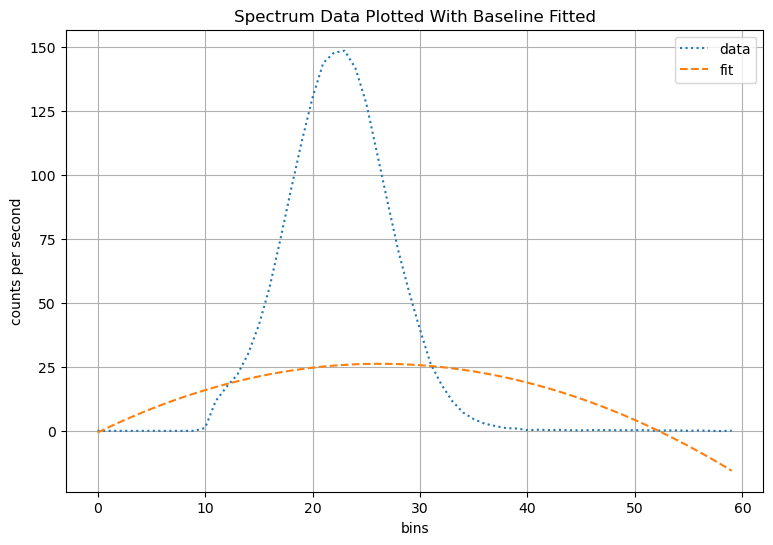

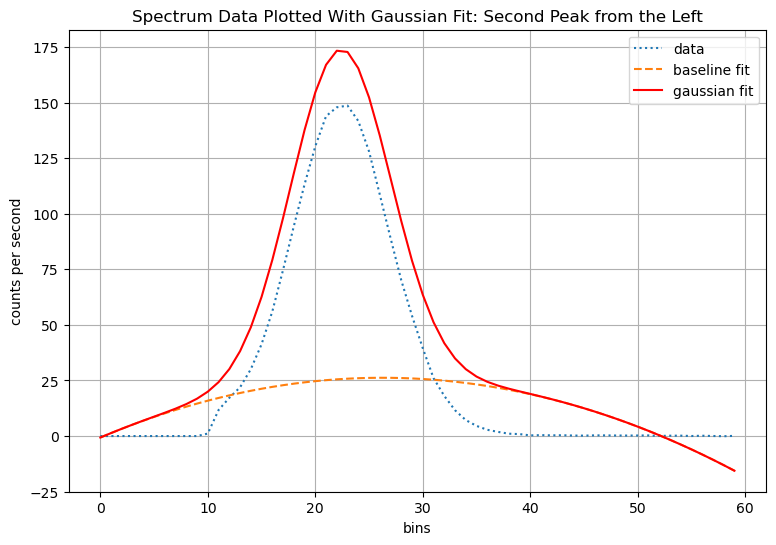

Parameters: 

Baseline Polynomial Fit: 
a = -0.0011742651647689455 +/- 0.0008487597111013093,
b = 0.06818411281347803 +/- 0.04848472683128223, 
c = -0.20301528412614495 +/- 0.5019880691265644
Gaussian Fit: 
mu0 = 22.37660154855446 +/- 0.020699177809972425,
sigma0 = -4.614543526616936 +/- 0.025702536923139205,
amp0 = 1715.8477417652268 +/- 11.855433273548552


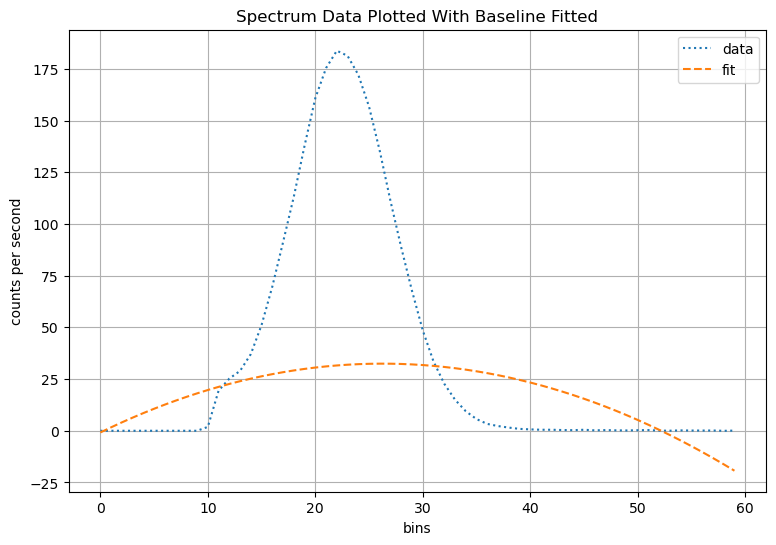

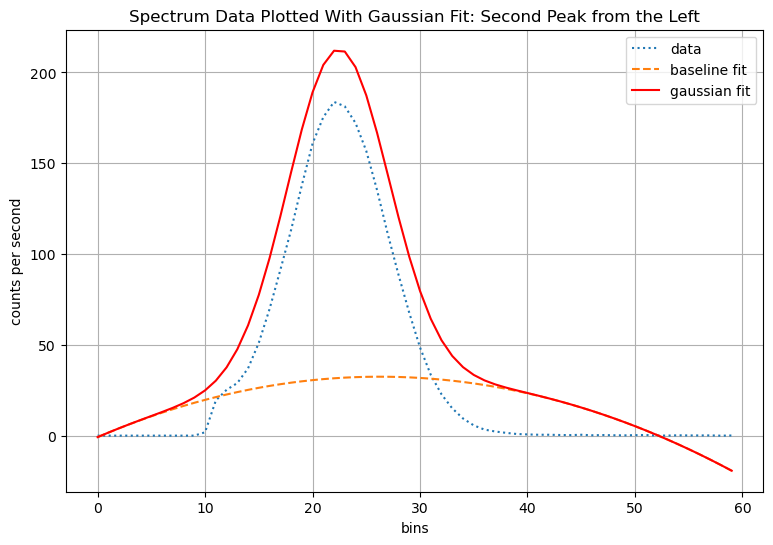

Parameters: 

Baseline Polynomial Fit: 
a = -0.0014920383684829345 +/- 0.0014974242115356276,
b = 0.07655037579994664 +/- 0.0854823950581242, 
c = 0.19171953517272575 +/- 0.8818775828229497
Gaussian Fit: 
mu0 = 22.403007785021117 +/- 0.02993694292458989,
sigma0 = -4.657434383259548 +/- 0.03728518276693884,
amp0 = 2113.5270628596963 +/- 21.0815531079477


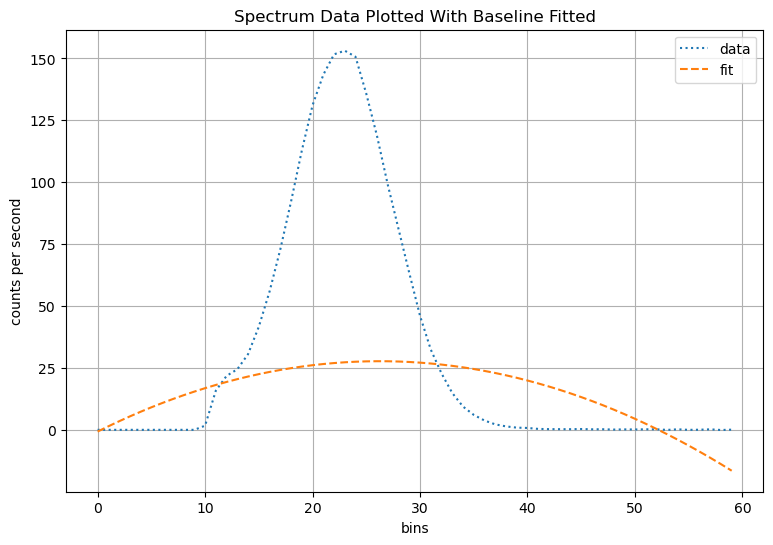

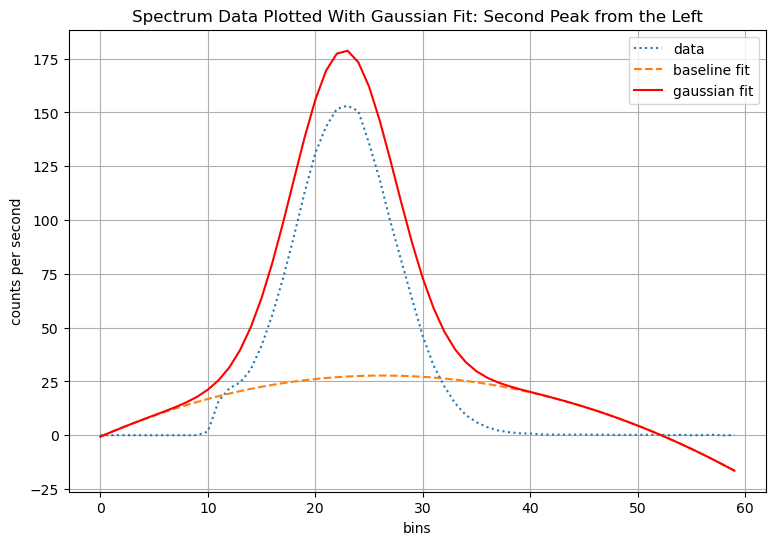

Parameters: 

Baseline Polynomial Fit: 
a = -0.0011860677937023014 +/- 0.0013742123026592764,
b = 0.05785267509653499 +/- 0.07839074036393902, 
c = 0.282251289806826 +/- 0.7950430270267903
Gaussian Fit: 
mu0 = 22.65738974735633 +/- 0.03249525124247228,
sigma0 = -4.743449111120633 +/- 0.040855475129683856,
amp0 = 1805.2443518088 +/- 19.595967986011573


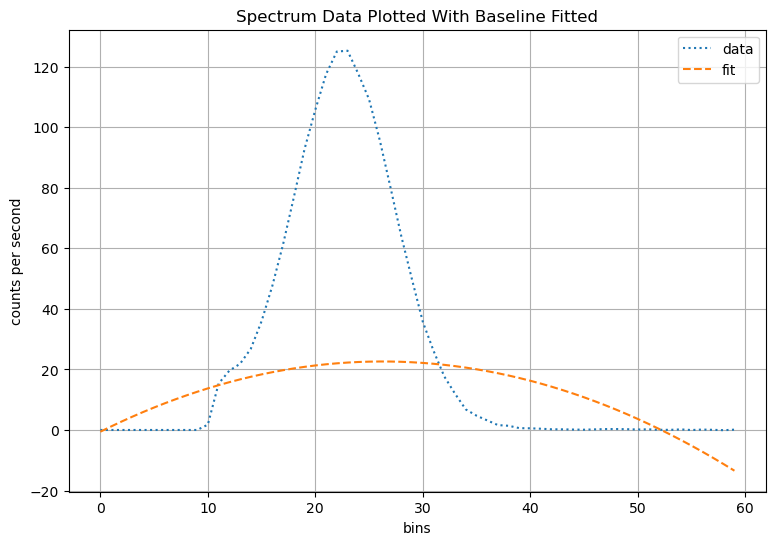

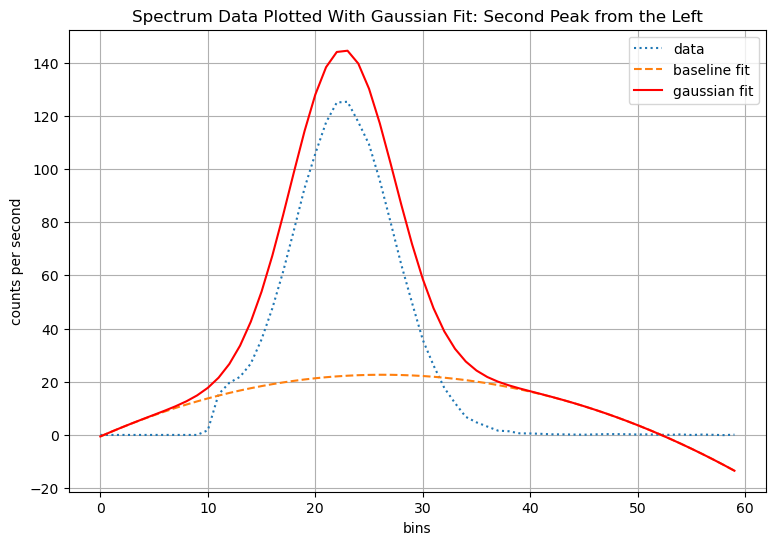

Parameters: 

Baseline Polynomial Fit: 
a = -0.0008232248999348753 +/- 0.0013057822645642229,
b = 0.03682176557929338 +/- 0.07440428846620104, 
c = 0.3729734233377116 +/- 0.7569437815454161
Gaussian Fit: 
mu0 = 22.540256914544614 +/- 0.03843533379030414,
sigma0 = -4.788001353173837 +/- 0.048364122324227946,
amp0 = 1473.465277200662 +/- 18.811071894132986


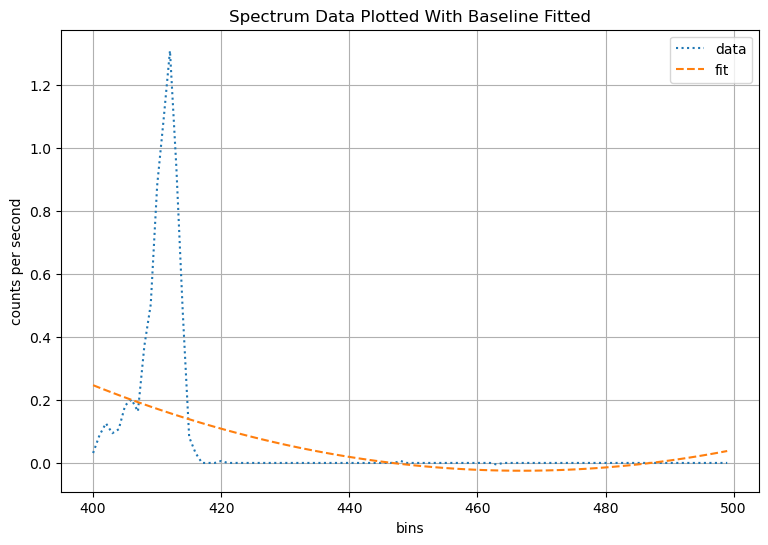

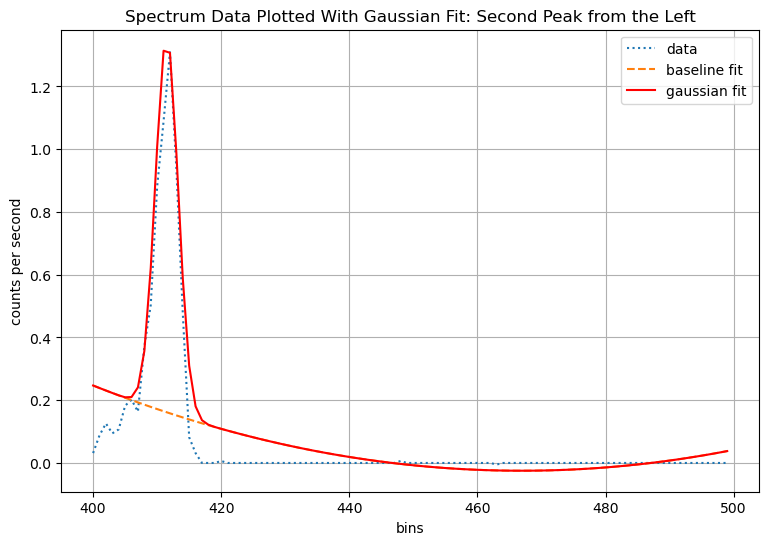

Parameters: 

Baseline Polynomial Fit: 
a = 2.6677215304250298e-05 +/- 5.066028825357026e-06,
b = -0.02470022006325118 +/- 0.004574821489066683, 
c = 5.704051244010178 +/- 1.029937412784506
Gaussian Fit: 
mu0 = 411.50054602889446 +/- 0.04269179856393122,
sigma0 = -1.7745160952946042 +/- 0.04585739977105246,
amp0 = 5.318161316985045 +/- 0.1343360902191915


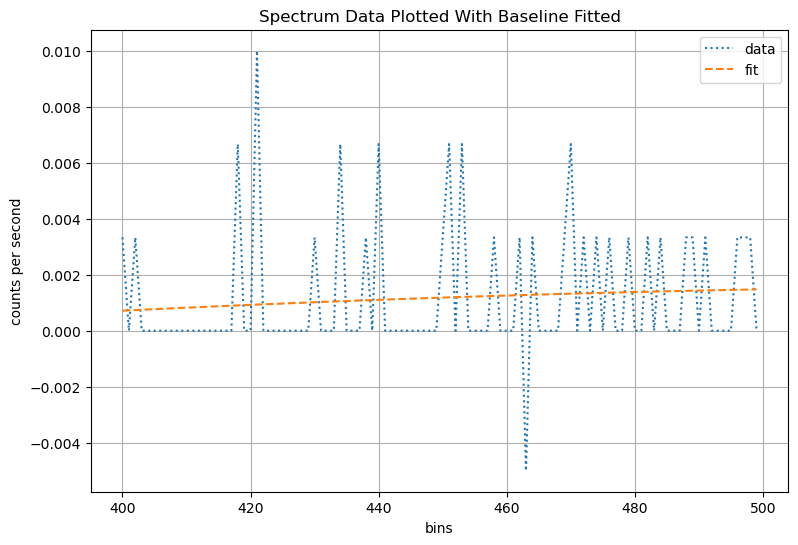

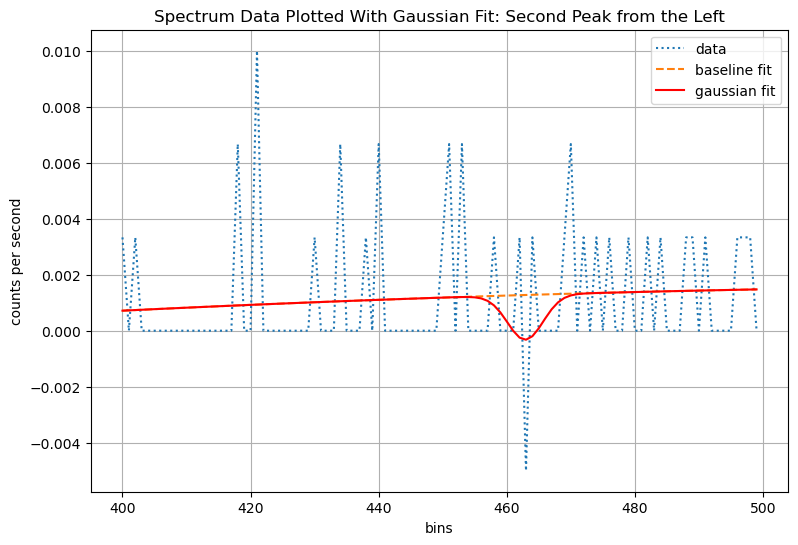

Parameters: 

Baseline Polynomial Fit: 
a = -1.646727378775704e-07 +/- 3.250097932384721e-07,
b = 0.00015750528482076396 +/- 0.00029287510016347767, 
c = -0.03612726787644917 +/- 0.06571950302738996
Gaussian Fit: 
mu0 = 462.90356803969485 +/- 2.5010294064619036,
sigma0 = 2.776845026215106 +/- 2.654675761480288,
amp0 = -0.011137390017505785 +/- 0.010265861510445683


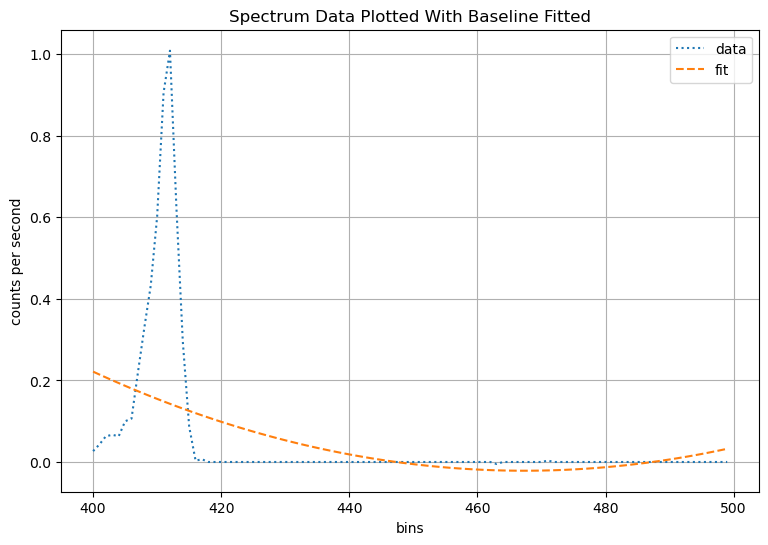

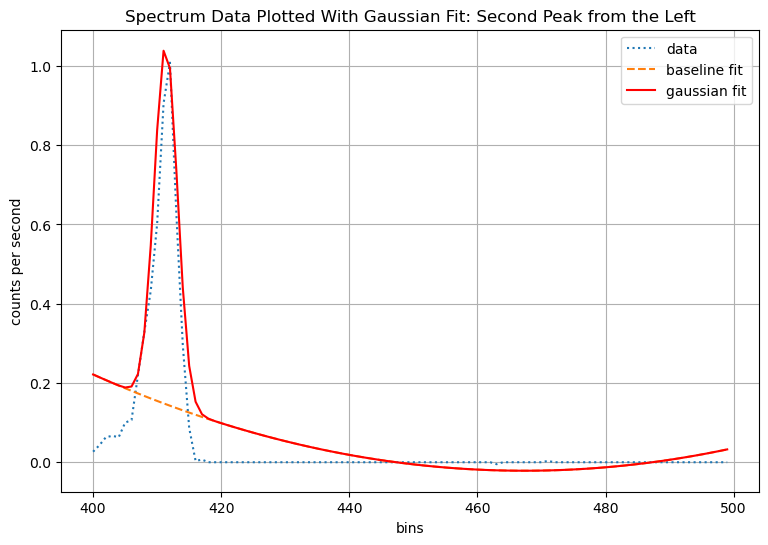

Parameters: 

Baseline Polynomial Fit: 
a = 1.7343909988413744e-05 +/- 4.258051409876398e-06,
b = -0.01605644902210582 +/- 0.0038458958682482574, 
c = 3.7074051337545573 +/- 0.8660060851843464
Gaussian Fit: 
mu0 = 411.35739901762463 +/- 0.047510985483953216,
sigma0 = -1.8029316037273013 +/- 0.05117011959634618,
amp0 = 4.1015005751982905 +/- 0.1142129983723359


In [171]:
BGO_0_peak,BGO_0_FWHM= gauss_fitter(BGO_0_table, range(0,60))
BGO_45_peak,BGO_45_FWHM = gauss_fitter(BGO_45_table, range(0,60))
BGO_90_peak,BGO_90_FWHM = gauss_fitter(BGO_90_table, range(0,60))
BGO_135_peak,BGO_135_FWHM = gauss_fitter(BGO_135_table, range(0,60))
BGO_165_peak,BGO_165_FWHM = gauss_fitter(BGO_165_table, range(0,60))

CdTe_0_peak,CdTe_0_FWHM = gauss_fitter(CdTe_0_table, range(400,500))
CdTe_90_peak,CdTe_90_FWHM = gauss_fitter(CdTe_90_table, range(400,500))
CdTe_135_peak,CdTe_135_FWHM = gauss_fitter(CdTe_135_table, range(400,500))

In [178]:
BGO_FWHM = {
    '0 degrees' : float(BGO_0_FWHM),
    '45 degrees' : float(BGO_45_FWHM),
    '90 degrees' : float(BGO_90_FWHM),
    '135 degrees' : float(BGO_135_FWHM),
    '165 degrees' : float(BGO_165_FWHM),
}

CdTe_FWHM = {
    '0 degrees' : float(CdTe_0_FWHM),
    '90 degrees' : float(CdTe_90_FWHM),
    '135 degrees' : float(CdTe_135_FWHM)
}

In [180]:
BGO_FWHM

{'0 degrees': -4.906331570815212,
 '45 degrees': -4.614543526616936,
 '90 degrees': -4.657434383259548,
 '135 degrees': -4.743449111120633,
 '165 degrees': -4.788001353173837}

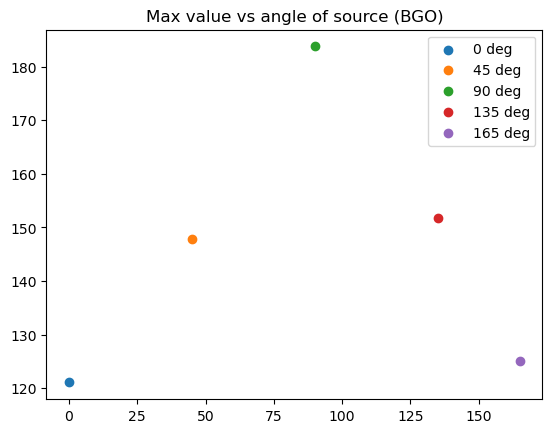

In [191]:
plt.scatter(0,BGO_0_table['counts/sec'][int(BGO_0_peak)],label = '0 deg')
plt.scatter(45,BGO_45_table['counts/sec'][int(BGO_45_peak)],label ='45 deg')
plt.scatter(90,BGO_90_table['counts/sec'][int(BGO_90_peak)],label ='90 deg')
plt.scatter(135,BGO_135_table['counts/sec'][int(BGO_135_peak)],label = '135 deg')
plt.scatter(165,BGO_165_table['counts/sec'][int(BGO_165_peak)],label = '165 deg')
plt.title('Max value vs angle of source (BGO)')
plt.legend()
plt.show()

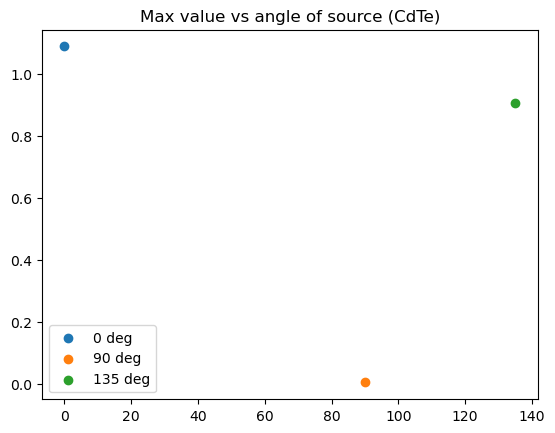

In [190]:
plt.scatter(0,CdTe_0_table['counts/sec'][int(CdTe_0_peak)],label = '0 deg')
plt.scatter(90,CdTe_90_table['counts/sec'][int(CdTe_90_peak)],label ='90 deg')
plt.scatter(135,CdTe_135_table['counts/sec'][int(CdTe_135_peak)],label = '135 deg')
plt.title('Max value vs angle of source (CdTe)')
plt.legend()
plt.show()